Test Jacobi-iterator for thermal problems using MFEANet

* Two-phase composite (one center circle + multiple circles pattern)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair

import matplotlib.pyplot as plt
import math
import time

from utils import plot
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from data.dataset import MechanicalDataSet


In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
bs = 1 # batch size
k = 0 # test data index
no_neumann = False
n_test = 2**6
test_set = MechanicalDataSet('data/data_Ti64/thermal_Ti64.h5', device)
# n_test = 2**5
# test_set = ThermalDataSet('data/thermal/thermal_test.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
elem_mask_test, node_mask_test, dirich_idx_test, dirich_value_test, neumann_idx_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))
solution_test, f_test, d_test, d_idx_test, t_idx_test, t_test, t_conn_test, m_test, emsk_test, nmsk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(elem_mask_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(node_mask_test[k], 0).to(device_predict))

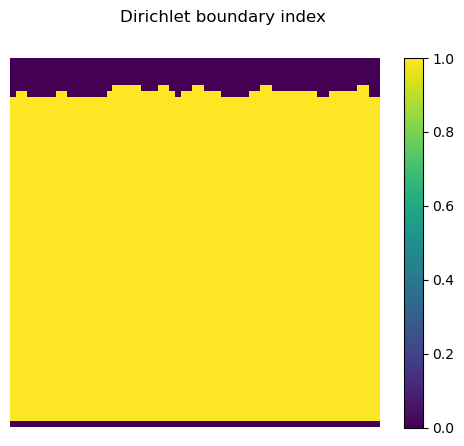

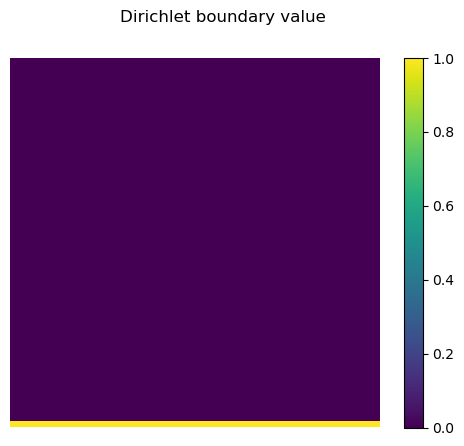

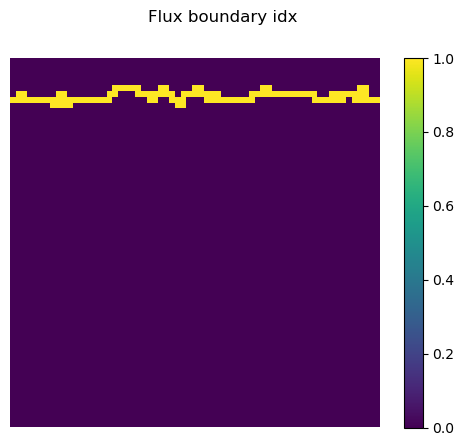

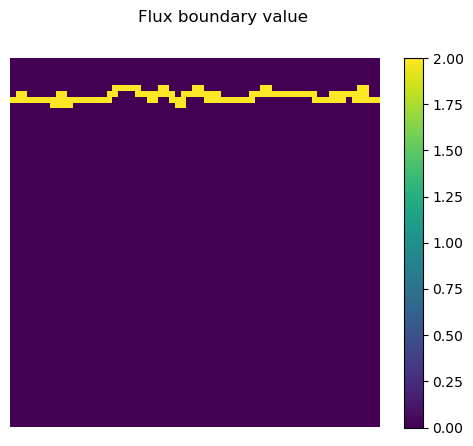

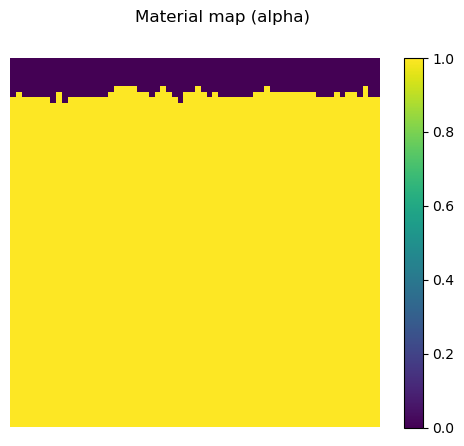

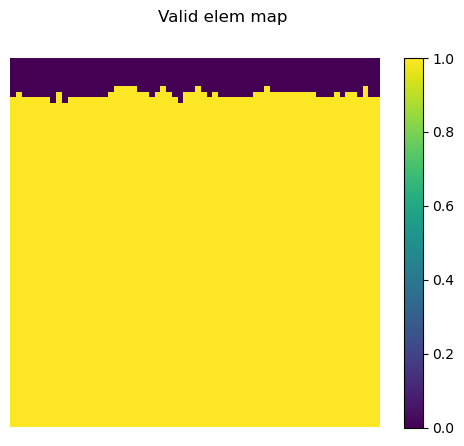

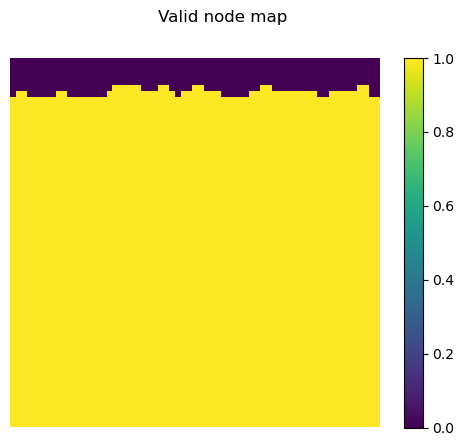

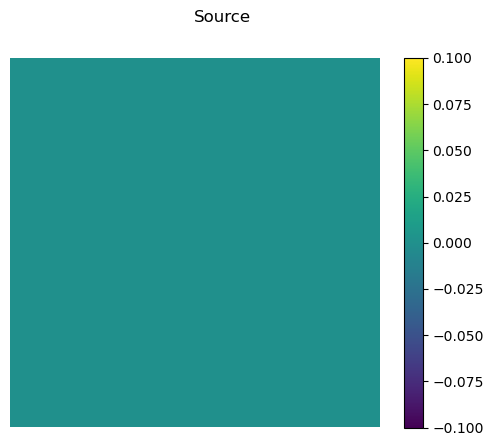

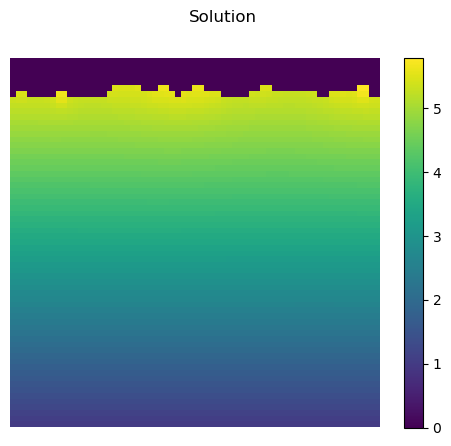

In [4]:
plot.plot_thermalfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_thermalfield(neumann_idx_test[k], ftitle='Flux boundary idx')
plot.plot_thermalfield(neumann_value_test[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_test[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(elem_mask_test[k], ftitle='Valid elem map')
plot.plot_thermalfield(node_mask_test[k], ftitle='Valid node map')
plot.plot_thermalfield(f_test[k], ftitle='Source')
plot.plot_thermalfield(u_test[k], ftitle='Solution')

In [5]:
n_elem = n_test
ku, kf = 1, 1
h = 0.0061*4
grid = SingleGrid(h, n_elem=n_elem, mode='thermal', dev=device_predict, no_neumann=no_neumann)

In [6]:
EPS = 1e-6
n_jac = 0
jacu_test = torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, h, jacu_test, d_idx_test, f_test, t_test, t_conn_test, m_test, nmsk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if(False):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, nmsk_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_conn_test)
        residual = grid.net(None, None, h, jacu_test, d_idx_test, f_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")
    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_thermalfield(jacu_test[0], "Benchmark")
    plot.plot_thermalfield(solution_test[0], "Test")
    plot.plot_thermalfield(jacu_test[0]-solution_test[0], 'Error')

## Test multigrid performance

In [7]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, no_neumann, pacnet=None, device=device, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(f_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 0.4867784617815831
1 0.5917969456861765
2 0.5480388577412607
3 0.5079689019180885
4 0.46726627670463783
5 0.42926195291950364
6 0.39403372651638996
7 0.36153562490872404
8 0.331611156240943
9 0.30408759497610877
10 0.2787916911322406
11 0.25555652083449276
12 0.23422388424143764
13 0.2146452306956338
14 0.19668187468640677
15 0.18020484784916524
16 0.1650945530225404
17 0.1512403130606313
18 0.1385398686522584
19 0.12689885757766936
20 0.11623029483680766
21 0.10645406521743003
22 0.09749643506886863
23 0.08928958709169599
24 0.08177118011267383
25 0.07488393465151043
26 0.06857524433895627
27 0.06279681275844466
28 0.057504314964548206
29 0.052657082722227695
30 0.04821781237885693
31 0.044152294202026585
32 0.040429161977159477
33 0.03701966164791048
34 0.03389743779356659
35 0.031038336763895006
36 0.02842022533017751
37 0.02602282375696733
38 0.023827552250785564
39 0.021817389796556782
40 0.01997674444908751
41 0.018291334203481918
42 0.016748077624858023
43 0.015334993472106888

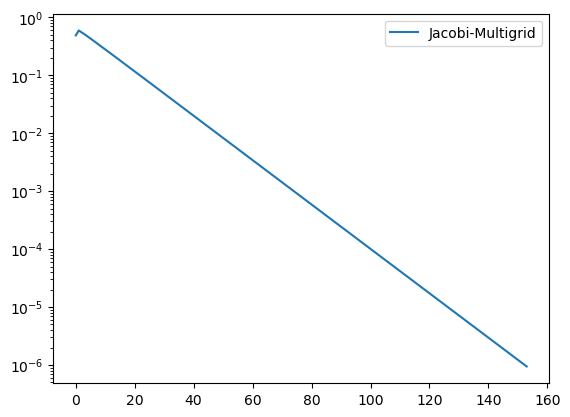

In [8]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()

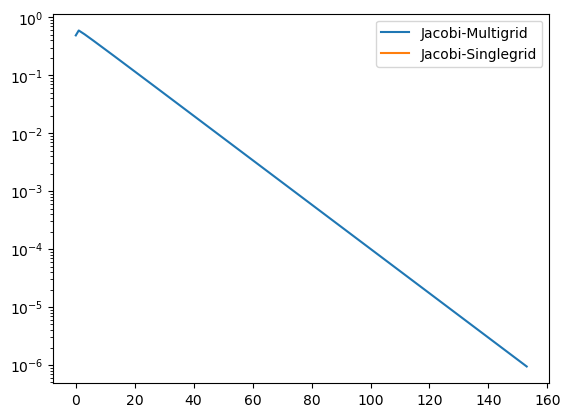

In [9]:
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.plot(res_arr, label='Jacobi-Singlegrid')
plt.yscale('log')
plt.legend()
plt.show()

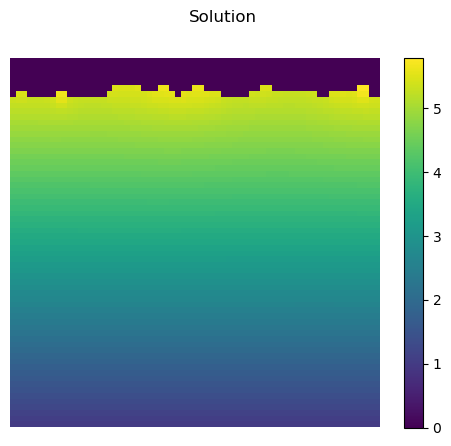

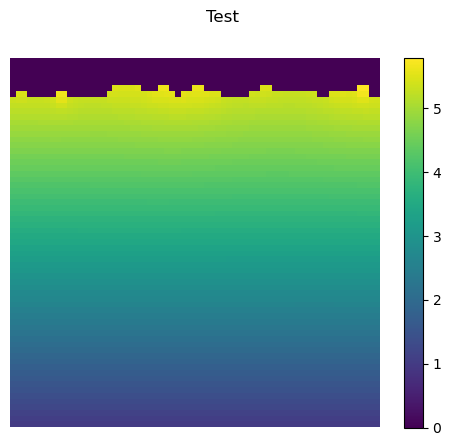

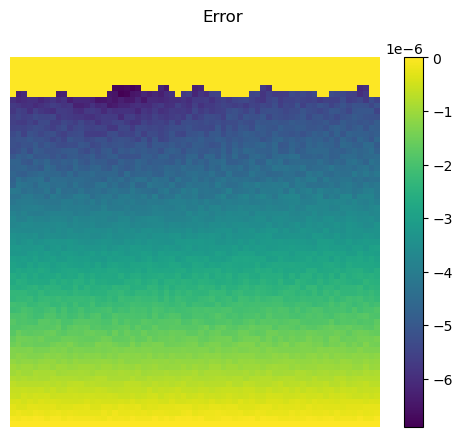

In [10]:
plot.plot_thermalfield(solution_test[0], "Solution")
plot.plot_thermalfield(u_mg_jac[0], "Test")
plot.plot_thermalfield(u_mg_jac[0]-solution_test[0], "Error")

In [11]:
from feanet.post_processing import ThermalPostProcessing
tPost = ThermalPostProcessing(h, m_test.float(), emsk_test.float(), nmsk_test.float())
flux = tPost.ComputeFlux(solution_test.float())
flux1 = tPost.ComputeFlux(u_mg_jac.float())

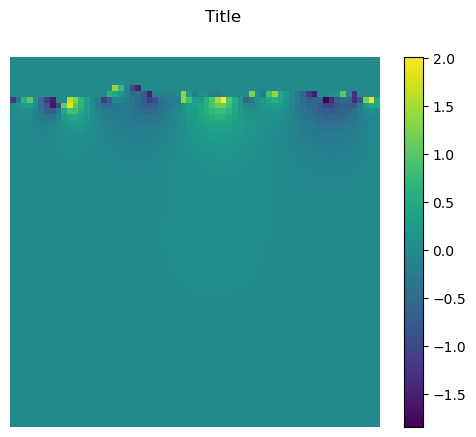

In [12]:
plot.plot_thermalfield(flux1[:,0])

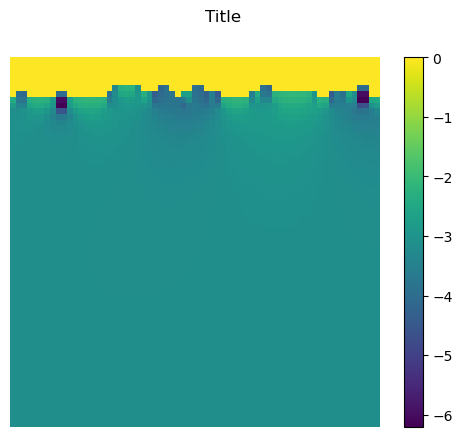

In [13]:
plot.plot_thermalfield(flux1[:,1])

In [14]:

emask_padded = F.pad(emsk_test, (1, 1, 1, 1), mode='constant', value=0)
kernel = torch.ones((1, 1, 2, 2), dtype=emask_padded.dtype)
count = F.conv2d(emask_padded, kernel, padding=0)